In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle
import os
import sys
from ephys import core, events, rasters
from neuraltda import topology
import glob
import string
from scipy.io import wavfile
import scipy.signal as signal
from scipy.interpolate import interp1d
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

%pylab inline
reload(topology)

Populating the interactive namespace from numpy and matplotlib


<module 'neuraltda.topology' from '/home/brad/code/NeuralTDA/neuraltda/topology.pyc'>

In [50]:
maxt = 100
prefix = 'B999'
def plotBarcodeRecursive(resDict):
    
    if 'barcodes' in resDict.keys():
        barcodeDat = resDict['barcodes']
        bettis = barcodeDat.keys()
        for betti in bettis:
            bettiBarcode = barcodeDat[betti]
            nlines = len(bettiBarcode)
            ycoords = [[s,s] for s in range(nlines)]
            xcoords = [[s[0], s[1]+maxt*(s[1] < 0)] for s in bettiBarcode]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords))
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotBarcodeRecursive(resDict[k])
            
def plotPersistenceDiagramRecursive(resDict):
    
    if 'barcodes' in resDict.keys():
        barcodeDat = resDict['barcodes']
        bettis = barcodeDat.keys()
        for betti in bettis:
            bettiBarcode = barcodeDat[betti]
            nlines = len(bettiBarcode)
            ycoords = [s[1]+max(max(bettiBarcode))*(s[1] < 0) for s in bettiBarcode]
            xcoords = [s[0] for s in bettiBarcode]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords), '.')
            plt.plot(np.linspace(0, maxt, 10), np.linspace(0, maxt, 10), 'k')
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.xlim([-2, maxt])
            plt.ylim([-2, maxt])
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotPersistenceDiagramRecursive(resDict[k])


def plotBettiCurveRecursive(resDict):
    
    if 'bettis' in resDict.keys():
        bettiDat = resDict['bettis']
        bettis = len(bettiDat[0][1])
        for betti in range(bettis):
            ycoords = [s[1][betti] for s in bettiDat]
            xcoords = [s[0] for s in bettiDat]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords))
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotBettiCurveRecursive(resDict[k])
            
def avgBettiRecursive(bettiDict, bettinum, runningSum, N, maxT, windt):
    if 'bettis' in bettiDict.keys():
        bettiT = np.array([s[0] for s in bettiDict['bettis']])*(windt/1000.)
        maxT = max(bettiT)
        try:
            bettiB = np.array([s[1][bettinum] for s in bettiDict['bettis']])
        except:
            
            bettiB = np.zeros(len(bettiT))
        bfunc = interp1d(bettiT, bettiB, kind='zero', bounds_error=False, fill_value=(bettiB[0], bettiB[-1]))
        t = np.linspace(0, maxT, 1000)
        bvals = bfunc(t)
        return (runningSum + bvals, N+1, maxT)
    else:
        for k in bettiDict.keys():
            runningSum, N, maxT = avgBettiRecursive(bettiDict[k], bettinum, runningSum, N, maxT, windt)
        return (runningSum, N, maxT)
    
def computeAvgBettiCurve(resDict, stim, betti, windt):
    
    stimdata = resDict[stim]
    
    runningSum, N, maxT = avgBettiRecursive(stimdata, betti, np.zeros(1000), 0, 0, windt)
    avgBetti = runningSum / float(N)
    t = np.linspace(0, maxT, len(avgBetti))
    
    return (avgBetti, t, maxT)
    
def plotAvgBettiCurves(avgBetti, t, betti, stim): 
    plt.figure()
    plt.plot(t, avgBetti)
    plt.title('Stim: %s Betti: %d' %(stim, betti))
    plt.ylim([0, max(avgBetti)+2])
    plt.xlim([0, max(t)])
    plt.show()
def plotStimAvgMinusTotalAvg(resDict, stim, betti):
    stimdata = resDict[stim]
    t = np.linspace(0, 2, 1000)
    runningSum, N = avgBettiRecursive(stimdata, betti, np.zeros(len(t)), 0, t)
    avgBetti = runningSum / float(N)
    
    totAvg, N = avgBettiRecursive(resDict, betti, np.zeros(len(t)), 0, t)
    totAvg = totAvg/float(N)
    
    
    plt.figure(figsize=(11, 8))
    plt.plot(t, avgBetti-totAvg)
    sns.despine()
    plt.title('Stim: %s Betti: %d' %(stim, betti))
    plt.ylim([-5, 5])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Difference')
    plt.savefig('{}-Stim_{}-Betti_{}.png'.format(prefix, stim, betti))
    plt.show()
    

In [63]:
resFname = '/home/brad/bcube/experiments/B1075/phy041216/Pen01_Lft_AP300_ML700__Site03_Z2700__B1075_cat_P01_S03_1/20161005T012837Z-25.0-4.0-masterResults.pkl'

with open(resFname, 'r') as f:
    mrDict = pickle.load(f)
    
computationClass = 'permuted'
results = mrDict[computationClass]
resultsSh = mrDict['permuted-shuffled']
stims = results.keys()



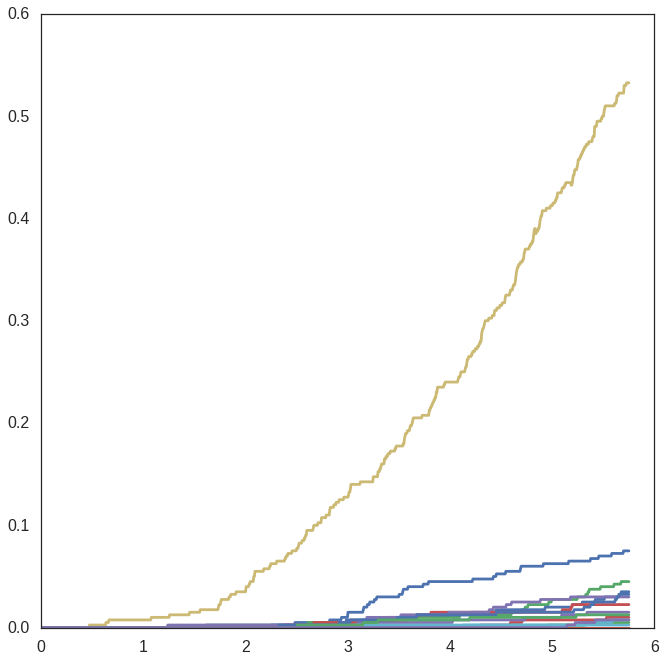

In [67]:
bettisave = np.zeros((1000, len(stims)))
betti = 1
windt = 25.0
for ind, stim in enumerate(stims):
    (avgBetti, t, maxT) = computeAvgBettiCurve(resultsSh, stim, betti, windt)
    bettisave[:, ind] = avgBetti
plt.figure(figsize=(11,11))    
plt.plot(t, bettisave)

In [75]:
MRs = glob.glob('/home/brad/bcube/experiments/B1083/klusta/phy040516/Pen03_Lft_AP0_ML1000__Site03_Z2700__B1083_cat_P03_S03_1/2016111*')

thresh = 4.0
changedt = [s for s in MRs if s.split('-')[2] == str(thresh)]
cdt_over = sort(changedt)[range(0, len(changedt), 2)]

# All Stims at once across params

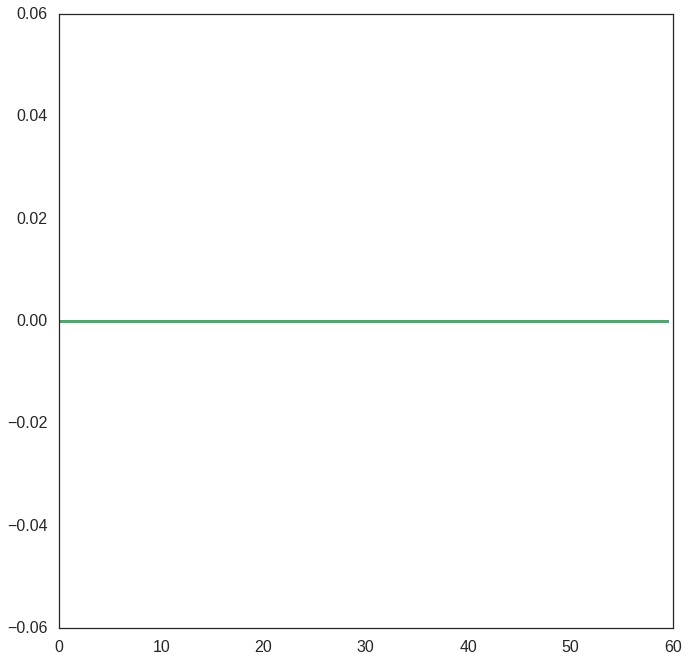

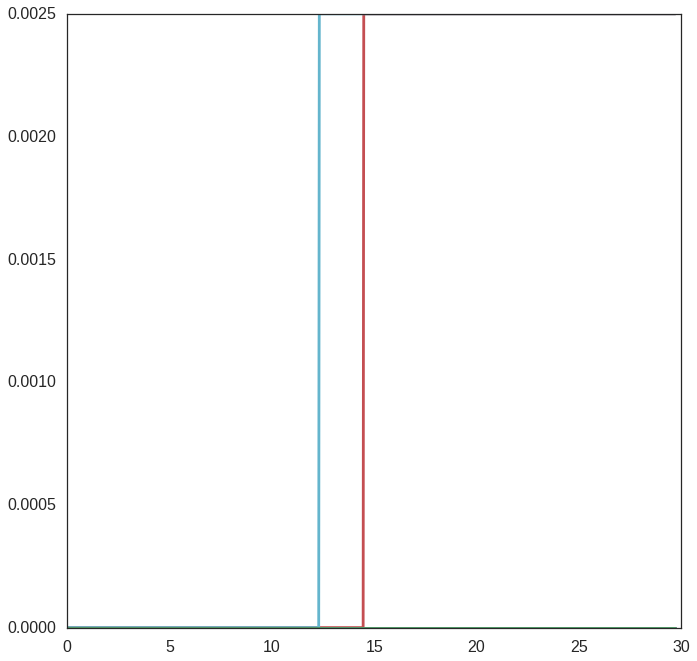

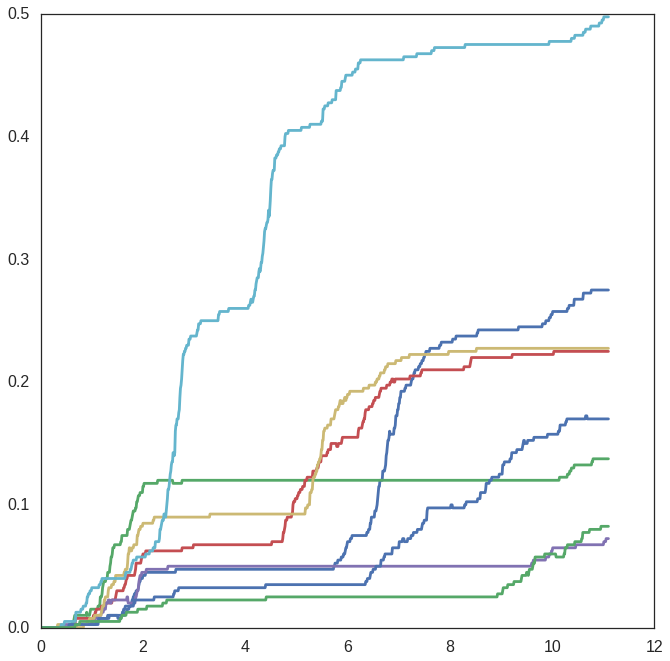

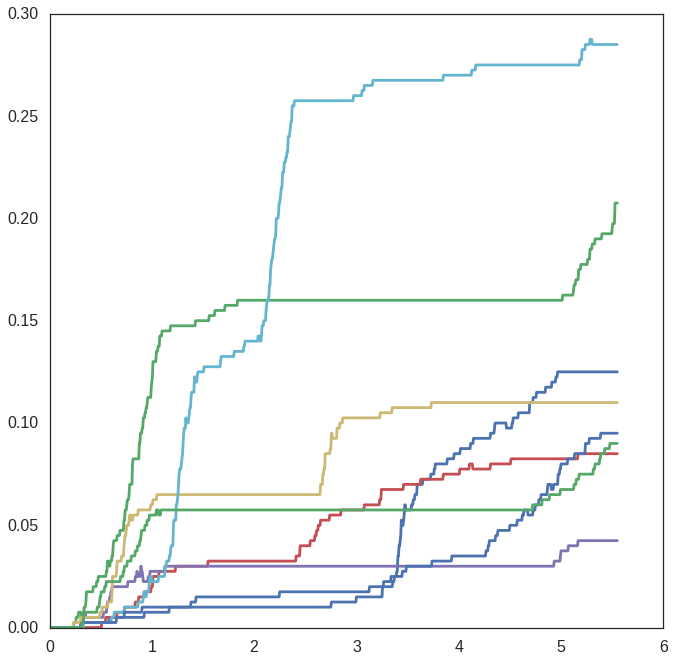

In [82]:
MRs = glob.glob('/home/brad/bcube/experiments/B1083/klusta/phy040516/Pen03_Lft_AP0_ML1000__Site03_Z2700__B1083_cat_P03_S03_1/2016111*')

thresh = 4.0
changedt = [s for s in MRs if s.split('-')[2] == str(thresh)]
cdt_over = sort(changedt)[range(1, len(changedt), 2)]

bettisave = np.zeros((1000, len(stims)))
for resFname in cdt_over:
    with open(resFname, 'r') as f:
        mrDict = pickle.load(f)
    
    computationClass = 'permuted'
    results = mrDict[computationClass]
    resultsSh = mrDict['permuted-shuffled']
    stims = results.keys()
    betti = 3
    for ind, stim in enumerate(stims):
        (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windt)
        bettisave[:, ind] = avgBetti
    plt.figure(figsize=(11,11))    
    plt.plot(t, bettisave)

# Single stim across windts on same plot - constant threshold

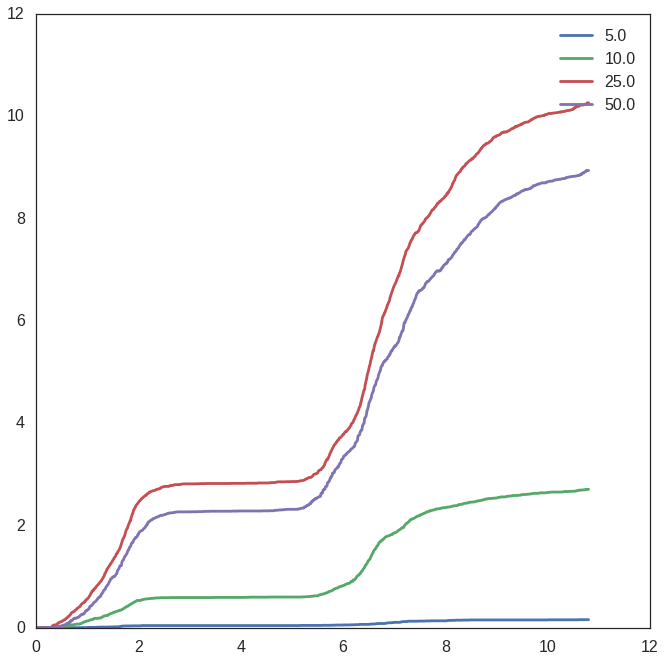

In [74]:
MRs = glob.glob('/home/brad/bcube/experiments/B1083/klusta/phy040516/Pen03_Lft_AP0_ML1000__Site03_Z2700__B1083_cat_P03_S03_1/2016111*')

thresh = 3.0
changedt = [s for s in MRs if s.split('-')[2] == str(thresh)]
cdt_over = sort(changedt)[range(1, len(changedt), 2)]

windts = [5.0, 10.0, 25.0, 50.0]
betti = 2
stim = 'K_40k'
bettisave = np.zeros((1000, len(cdt_over)))
for ind, resFname in enumerate(cdt_over):
    with open(resFname, 'r') as f:
        mrDict = pickle.load(f)
    
    computationClass = 'permuted'
    results = mrDict[computationClass]
    (avgBetti, t, maxT) = computeAvgBettiCurve(results, stim, betti, windts[ind])
    bettisave[:, ind] = avgBetti
plt.figure(figsize=(11,11))    
plt.plot(t, bettisave)
plt.legend(windts)

In [61]:
results['K_40k']['10']

{'0': {'barcodes': {'0': [[59, 62],
    [22, 63],
    [5, -1],
    [6, -1],
    [10, -1],
    [15, -1],
    [18, -1],
    [53, -1],
    [70, -1],
    [97, -1]],
   '1': []},
  'bettis': [[5, [1, 0]],
   [6, [2, 0]],
   [10, [3, 0]],
   [15, [4, 0]],
   [18, [5, 0]],
   [22, [6, 0]],
   [53, [7, 0]],
   [59, [8, 0]],
   [62, [7, 0]],
   [63, [6, 0]],
   [70, [7, 0]],
   [97, [8, 0]]],
  'hstr': u'K_40k--10-0'},
 '1': {'barcodes': {'0': [[60, 61],
    [59, 62],
    [22, 63],
    [5, -1],
    [6, -1],
    [10, -1],
    [15, -1],
    [18, -1],
    [53, -1],
    [97, -1]],
   '1': []},
  'bettis': [[5, [1, 0]],
   [6, [2, 0]],
   [10, [3, 0]],
   [15, [4, 0]],
   [18, [5, 0]],
   [22, [6, 0]],
   [53, [7, 0]],
   [59, [8, 0]],
   [60, [9, 0]],
   [61, [8, 0]],
   [62, [7, 0]],
   [63, [6, 0]],
   [97, [7, 0]]],
  'hstr': u'K_40k--10-1'},
 '10': {'barcodes': {'0': [[60, 61],
    [59, 62],
    [22, 63],
    [5, -1],
    [6, -1],
    [10, -1],
    [15, -1],
    [18, -1],
    [53, -1],
    [70,